## Project description

The customer is a telecommunications operator "Notasinglebreak.com". They want to learn to make predictions about  cancelations among their clients. And in case a client would like to cancel their contract the company could suggest some promotions and special conditions.

The team of the customer collected personal data about some of their clients: information about tariffs and contracts. There are 4 given datasets:

1. `contract.csv` — info about contracts;
2. `personal.csv` — personal client data;
3. `internet.csv` — info about web services;
4. `phone.csv` — info about phone services.

The public key for all these datasets: customerID (client's code).

All these datasets are up to date as of 1 February 2020.

### Description of services provided by the customer

Main services:

1. A landline telephone. There is a possibility to connect a telephone device to several lines at the same time.
2. The Internet. There are two types of connection: DSL and Fiber optic.

Extra services:
* Cyber-security: antivirus (DeviceProtection) and block unsafe sites (OnlineSecurity);
* A separate line for tech support (TechSupport);
* A cloud storage for backups (OnlineBackup);
* A streaming television (StreamingTV) and a catalog of movies (StreamingMovies).

Clients can pay for these services each month or once a year or two. Different payment ways and e-checks are available.

## Data loading

First, let's take a look at the data.

### Install libraries

Let's update and install the libraries that we will need in the development of the project:

In [1]:
!pip install xgboost
!pip install phik
!pip install -U matplotlib
!pip install -U scikit-learn
!pip install -U seaborn
!pip install category_encoders
!pip install shap
!pip install requests

In [2]:
import category_encoders as ce
import functools as ft
import io
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import phik
import requests
import seaborn as sns
import shap
import warnings

from phik import resources, report
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

RANDOM_STATE = 130323

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Familiarization with the given data

There are four files with the given data. Let's read them:

In [3]:
url = [] #the list with given urls
url =['https://13dagger.com/datasets/contract.csv', 'https://13dagger.com/datasets/internet.csv', 
       'https://13dagger.com/datasets/personal.csv','https://13dagger.com/datasets/phone.csv']

def read_content(url): #function to read the content from the url 
    s = requests.get(url).content
    return io.StringIO(s.decode('utf-8'))

In [4]:
try:
    df_contract = pd.read_csv(read_content(url[0]))
    df_internet = pd.read_csv(read_content(url[1])) 
    df_personal = pd.read_csv(read_content(url[2]))
    df_phone = pd.read_csv(read_content(url[3]))
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv') 
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

Let'd create a special function for reading datasets:

In [5]:
def get_data_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print()
    print()

In [6]:
for i in [df_contract, df_internet, df_personal, df_phone]:
  get_data_info(i)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


**Intermediate conclusion:**
* I need to join all four dataframes for analyzing data and building prediction models. By public key - `customerID`;
* There are no obvious missing values in all four datasets. I should check them after joining. And also I need to check unique values in all categorical features for implicit duplicates;
* Some features have incorrect format. For example, `TotalCharges` in the *df_contract* table (*object* -> *float64*). I need to fix it;
* There is no explicit target feature in the given data. It needs to be created.

## Data preparation

### Join datasets

To process the data, analyze it and build a model, I will need a common dataset consisting of four source tables. Join four given datasets to one by column `customerID`:

In [7]:
df_list = [df_contract, df_internet, df_personal, df_phone] #list of sourse datasets
df = ft.reduce(lambda left, right: pd.merge(left, right, how='outer', on='customerID'), df_list)

Checking the shape of resulting dataframe:

In [8]:
df.shape

(7043, 20)

It looks correct.

### Data preprocessing

I'm checking again which types of features should be changed:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


The plan of type casting is:
* `BeginDate` and `EndDate` - have to be converted to *datetime* data type;
* `TotalCharges` - convert to float type *float64*;
* `SeniorCitizen` - convert to *object* type because it is a categorical feature.

In [10]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='ignore')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df['SeniorCitizen'] = df['SeniorCitizen'].apply(str)

Checking the types:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

Type conversions happened correctly.

#### Checking missing meaning

When joining datasets, visible gaps appeared. Let's print them in descending order:

In [12]:
df.isna().sum().sort_values(ascending=False).head(11)

OnlineBackup        1526
InternetService     1526
StreamingMovies     1526
StreamingTV         1526
TechSupport         1526
DeviceProtection    1526
OnlineSecurity      1526
MultipleLines        682
TotalCharges          11
MonthlyCharges         0
BeginDate              0
dtype: int64

`OnlineBackup`, `InternetService`, `StreamingMovies`, `StreamingTV`, `TechSupport`, `DeviceProtection`, and `OnlineSecurity` have a similar big number of gaps.
<br>Probably, they appeared because some clients don't use Internet services. I can replace them with just "No".

In [13]:
list_internet = [
    'OnlineBackup', 'InternetService', 'StreamingMovies', 'StreamingTV', 
    'TechSupport', 'DeviceProtection', 'OnlineSecurity'
    ]

df.loc[:, list_internet] = df.loc[:, list_internet].fillna('No')

The rest of the features with gaps is `MultipleLines` feature: this is probably someone who does not use multichannel communication.
And in `TotalCharges` - in the total payment.

The first of them I also can replace with "No".
For the second: should check the value of other features.

In [14]:
df['MultipleLines'] = df['MultipleLines'].fillna('No')

In [15]:
df[df['TotalCharges'].isna() == True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,DSL,Yes,No,Yes,Yes,Yes,No,Female,0,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,No,No,No,No,No,No,No,Male,0,No,Yes,No
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,DSL,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,Yes
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,No,No,No,No,No,No,No,Female,0,Yes,Yes,No
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,No,No,No,No,No,No,No,Male,0,Yes,Yes,No
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,DSL,No,Yes,Yes,Yes,Yes,No,Female,0,Yes,Yes,Yes


Actually, objects with missing values in `TotalCharges` are new clients whose connection date matches the data collection date. They haven't had any payment yet.
<br>This type of object is less than 1% of full data, their duration of using the company's services is 0 days. I can just delete these objects.

In [16]:
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

Checking if are there any gaps now:

In [17]:
df.isna().sum().sort_values(ascending=False).head()

customerID       0
BeginDate        0
Dependents       0
Partner          0
SeniorCitizen    0
dtype: int64

There are not any gaps. I can start the next step.

#### Checking for duplicates

First, let's check the explicit duplicates.

In [18]:
df.duplicated().sum()

0

There are no explicit duplicates.

Now, let's check implicit duplicates. For this, I'm going to check the unique meaning of categorical features:

In [19]:
object_categories = df.columns[df.dtypes==object]

for i in object_categories:
  print(df[i].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
['DSL' 'Fiber optic' 'No']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['Female' 'Male']
['0' '1']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']


There are no implicit duplicates either.

#### Checking for outliers

Outliers can interfere with conducting analyses correctly and building prediction models. Let's check if are they here with charts.

In [20]:
def make_hist(col):
  plt.figure(figsize=(12, 5))
  plt.hist(df[col], bins=100)
  plt.title(col)
  plt.show();

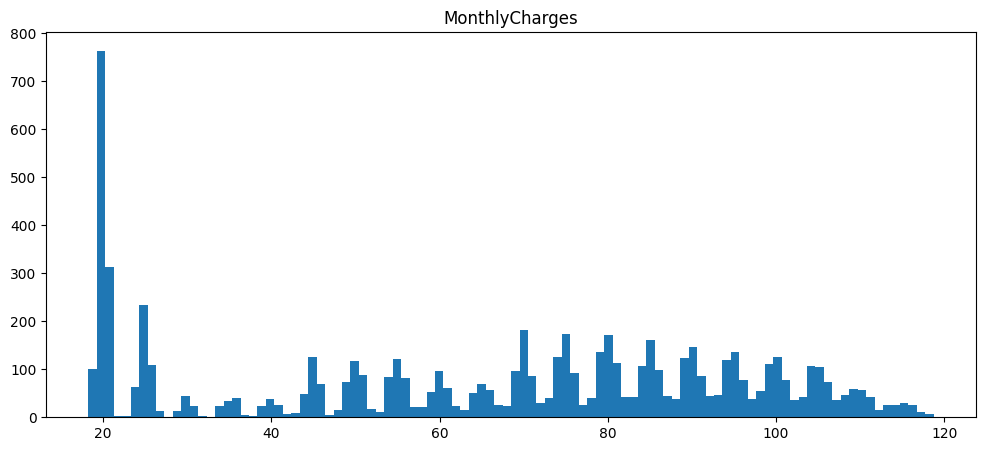

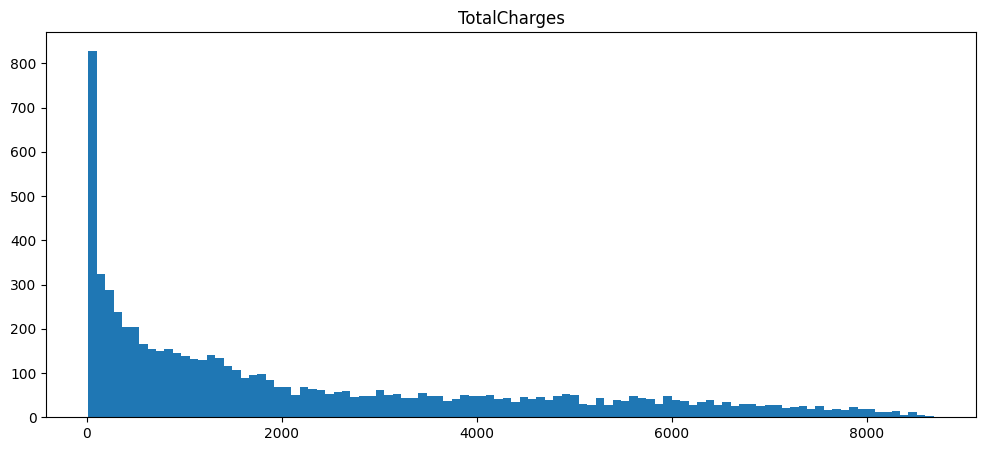

In [21]:
float_features = df.columns[df.dtypes==float]

for i in float_features:
  make_hist(i)

The feature `MonthlyCharges`. 
<br>In the chart, the peaks appear in numbers that are multiple of five, starting from 20. The most popular value is 20, it's basically the most popular tariff among clients.
<br>There is not any suspicious values. I can make the conclusion that there are no outliers.

The feature `TotalCharges`. 
<br>There are also no observed signs of outliers. There is one pronounced peak in the value near zero, but not zero. Perhaps, this is the total charge of clients who choose a tariff with 20 currency units per month. 
<br>All values looks normal, too.

There is one more feature in the data set with a numeric data type - `SeniorCitizen`. But, in fact, it is categorical.
<br>Just in case, let's check its exceptional values:

In [22]:
df['SeniorCitizen'].unique()

array(['0', '1'], dtype=object)

It also contains the expected set of values.

### Creating additional features

The cancelation date is not informative for current clients. I suggest creating a new feature based on it - the duration of the connection. This will be the difference between the date of connection and the date of data collection (02/01/2020) and for former clients - the date of termination of the contract.

Let's form a new attribute `Duration`:

In [23]:
df['EndDate'] = pd.to_datetime(df['EndDate'].replace('No', '2020-02-01 00:00:00')) #let's substitute the gaps with the date of data collection
df['Duration'] = (df['EndDate'] - df['BeginDate']).dt.days

df['Duration'] = pd.to_numeric(df['Duration']) #for convenience, let's convert this feature into *float*

df[['BeginDate', 'EndDate', 'Duration']].head(10) #checking if the number of days is counted correctly

,BeginDate,EndDate,Duration
0,2020-01-01,2020-02-01,31
1,2017-04-01,2020-02-01,1036
2,2019-10-01,2019-12-01,61
3,2016-05-01,2020-02-01,1371
4,2019-09-01,2019-11-01,61
5,2019-03-01,2019-11-01,245
6,2018-04-01,2020-02-01,671
7,2019-04-01,2020-02-01,306
8,2017-07-01,2019-11-01,853
9,2014-12-01,2020-02-01,1888


The feature `Duration` was created correctly.

### Creating of the target feature

The goal of the project is to predict customer churn. Accordingly, the feature `EndDate` can be taken as the target feature, as a binary classification.
<br>If it is not equal to the data collection date February 1, 2020, its value becomes 1. If it is equal - 0.

Creating the target feature `ExClients`:

In [24]:
df['ExClients'] = (df['EndDate'] != '2020-02-01').astype(int)

df[['EndDate', 'ExClients']].head(10) #checking that the target feature is formed correctly

,EndDate,ExClients
0,2020-02-01,0
1,2020-02-01,0
2,2019-12-01,1
3,2020-02-01,0
4,2019-11-01,1
5,2019-11-01,1
6,2020-02-01,0
7,2020-02-01,0
8,2019-11-01,1
9,2020-02-01,0


The target feature is created correctly.

## Data analysis

In this step, I should check if is there any data leakage. For that, I check correlations of numerical and categorical features. Some features might need to be deleted from the dataset.
<br>Also, I will check the interrelationships between the target and other features.

### Testing numerical features with Pearson correlation

Let's build the heat map for the correlation of numerical features.
<br>For now, the data types are:

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   7032 non-null   object        
 9   OnlineSecurity    7032 non-null   object        
 10  OnlineBackup      7032 non-null   object        
 11  DeviceProtection  7032 non-null   object        
 12  TechSupport       7032 non-null   object        
 13  StreamingTV       7032 non-null   object        
 14  StreamingMovies   7032 n

The features `SeniorCitizen` and `ExClients` are categorical, although they have a numeric type. The Pearson correlation will not be applicable to them.

Let's create a dataset slice with numerical features: `MonthlyCharges`, `TotalCharges`, and `Duration`:

In [26]:
df_num = df[['MonthlyCharges', 'TotalCharges', 'Duration']]

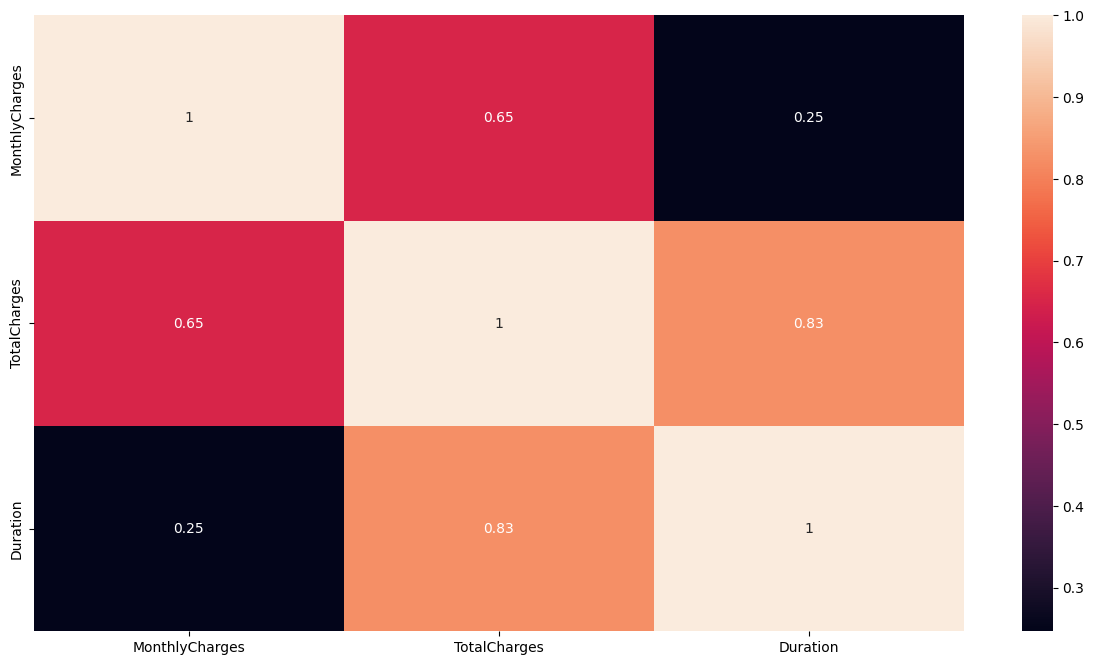

In [27]:
plt.figure(figsize = (15,8))
sns.heatmap(df_num.corr(), annot=True)
plt.show();


As seen from the heat map, the feature `TotalCharges` has a strong correlation with `MonthlyCharges` and `Duration`.

### Testing categorical features for multicollinearity

The next step is to check categorical features with the Phik correlation.

As the Phik correlation can be used for categorical and numerical features successively, I'm going to use the full dataset for the next heat map.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Duration', 'ExClients']


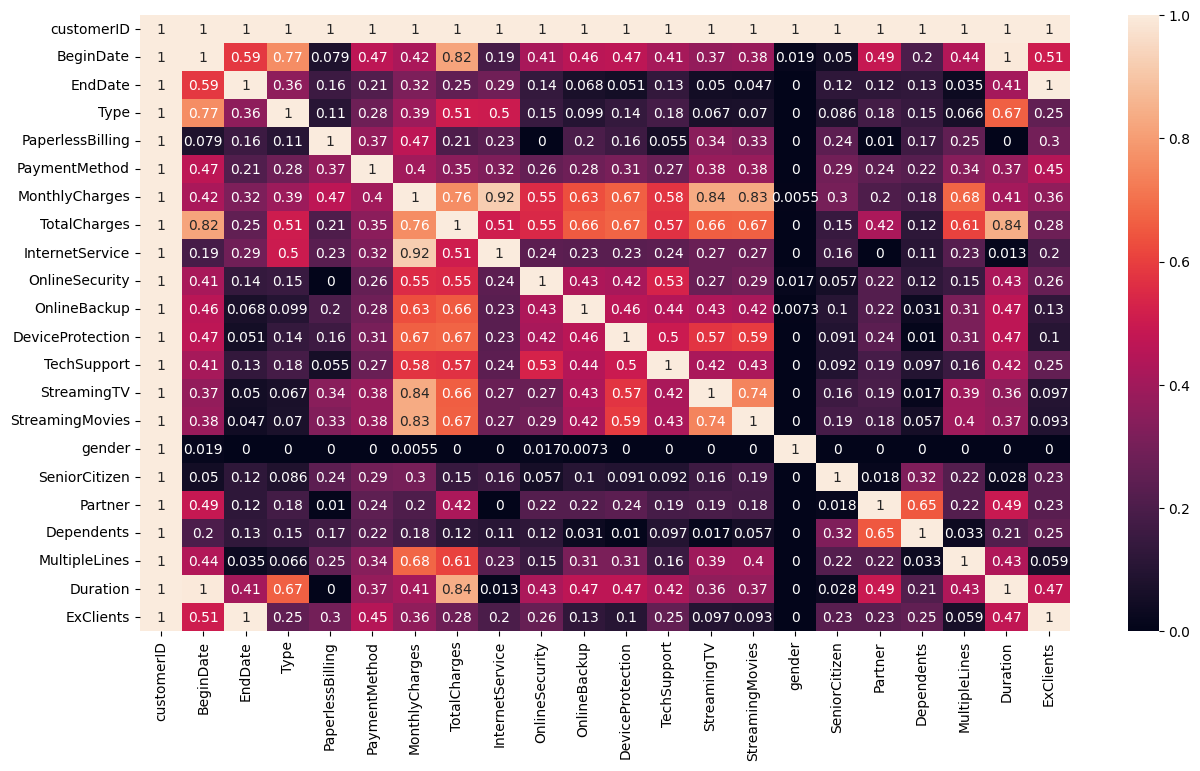

In [28]:
plt.figure(figsize = (15, 8))
sns.heatmap(df.phik_matrix(), annot=True)
plt.show();

As seen on the matrix, there are some correlated features. Since this correlation shows non-linear dependencies and the project is faced with the task of classifying, the correlated features should not greatly interfere with the training of models. But some of them are better to remove:
* The `customerID` feature correlates with all the others. I used it for merging. Now it doesn't have any useful information, because it is unique for each row. It is better to remove it;
* There is a big correlation between target feature `ExClients` and contract end date `EndDate`. It makes sense because I made the first one using the second. To avoid data leakage when training the model, the `EndDate` feature must also be removed;
* The similar situation with `BeginDate` and `Duration`. In addition, they can be used to restore the `EndDate` values, and again there will be a data leak. `BeginDate` will also need to be removed.

### Checking the relationship between the target feature on others

Let's check if there is any correlation between the target feature `ExClients` and others. I'm going to check both the features strongly correlated with the target one and the features that are potentially correlated with it.
<br>Additionally, I'm going to check how the end dates and start dates of the contract are distributed.

In other words, the check-list is:
* density charts for the start and end dates of the contract,
* chart of the relationship between the duration of the contract and the value of the target feature,
* charts of relationship between the monthly and total payment and the target features.

First-off, a chart of distribution for the start and end dates of the contract.

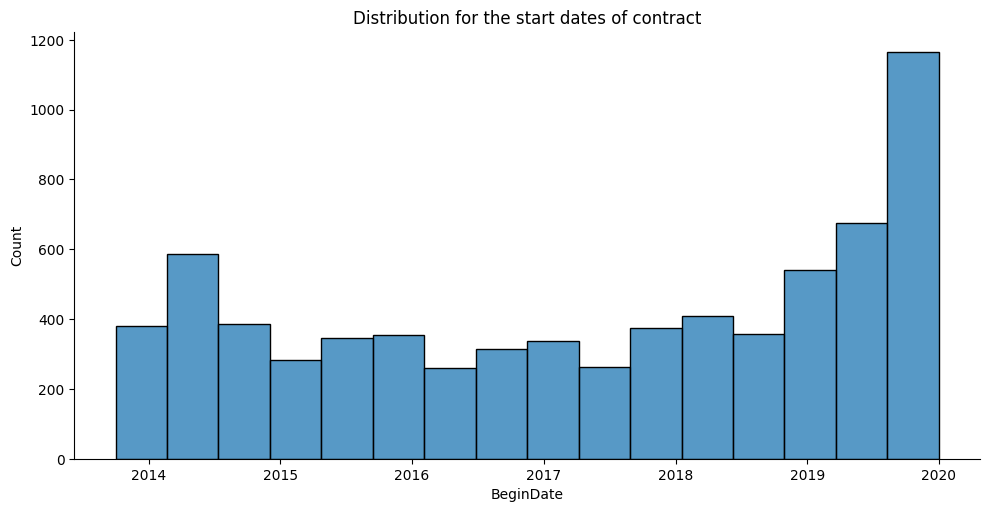

In [29]:
sns.displot(x='BeginDate',
            data=df, 
            height=5,
            aspect=2)
plt.title('Distribution for the start dates of contract')
plt.show();

Recently, there have been more and more new clients.

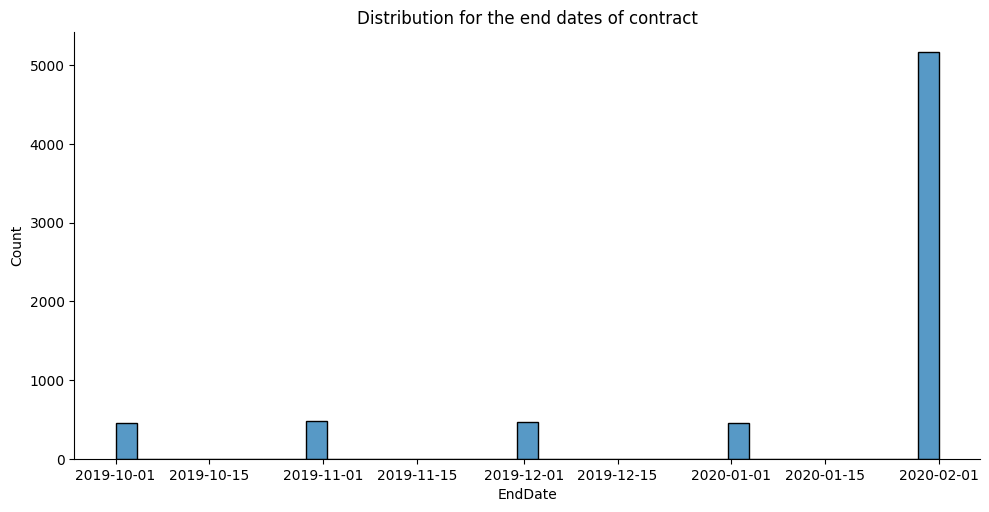

In [30]:
sns.displot(x='EndDate',
            data=df, 
            height=5,
            aspect=2)
plt.title('Distribution for the end dates of contract')
plt.show();

There are only four unique values for the end date contract (I ignore the date of collection of the data).

Let's build a plot that shows the relationship between the category of the target attribute and the duration of the client's contract.

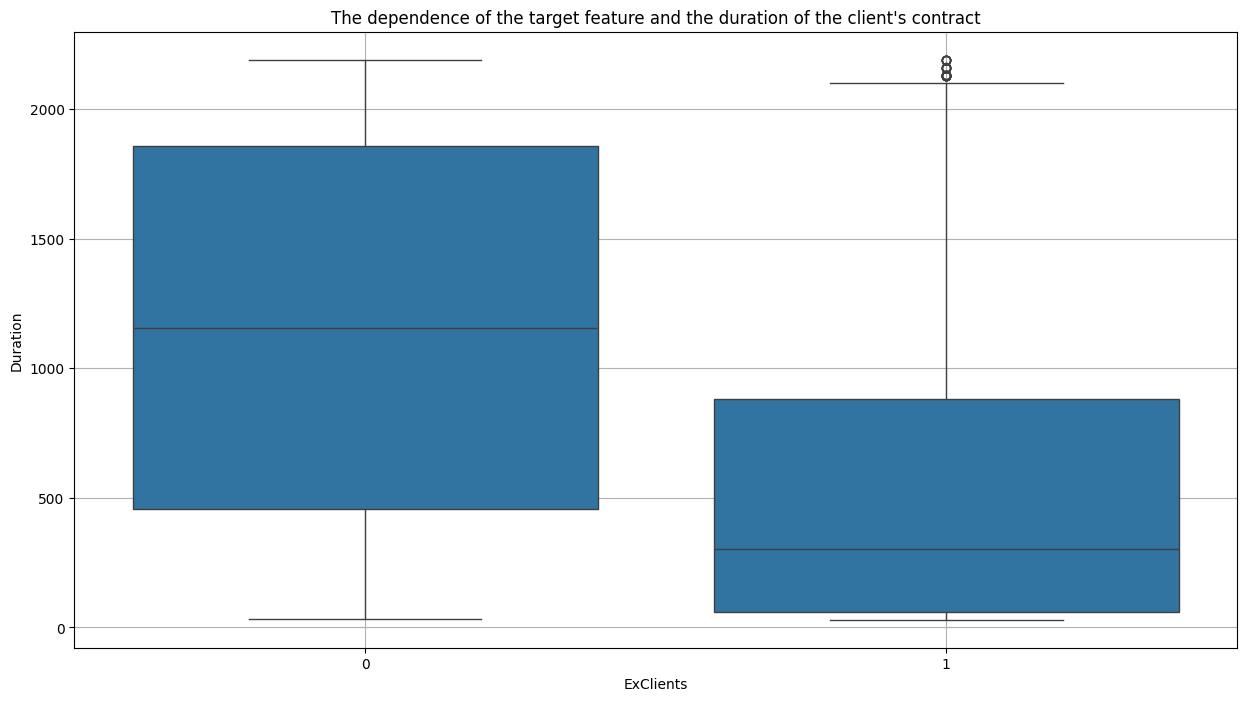

In [31]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df, 
            x='ExClients',
            y='Duration')
plt.title("The dependence of the target feature and the duration of the client's contract")
plt.grid()
plt.show();

As seen from the chart, the median duration of the contract for ex clients is less.
<br>Nevertheless, there are single values of users who terminated the contract after long-term use - outliers in class 1 of the target feature.

Let's check how monthly and total payments and clients leaving are connected.

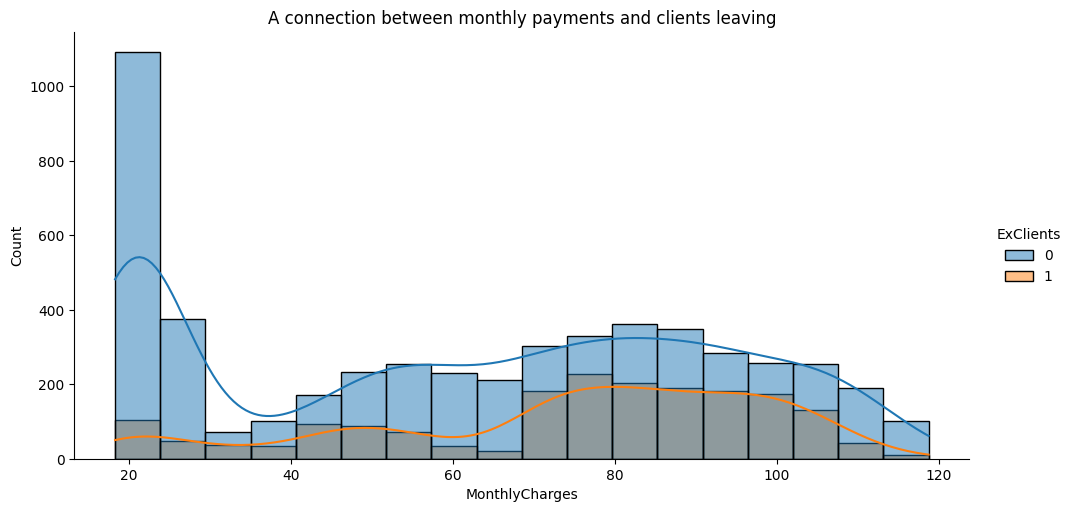

In [32]:
sns.displot(x='MonthlyCharges',
            hue='ExClients',
            data=df,
            height=5,
            aspect=2,
            kde=True)
plt.title("A connection between monthly payments and clients leaving")
plt.show();

Clients whose monthly payment was between 75 and 100 cash (CU) were more likely to terminate the contract. Perhaps the customer in this segment has a less competitive tariff.

The most popular tariff for current clients is 20 monetary units.
<br>Checking that this is due to the significant growth of new customers.

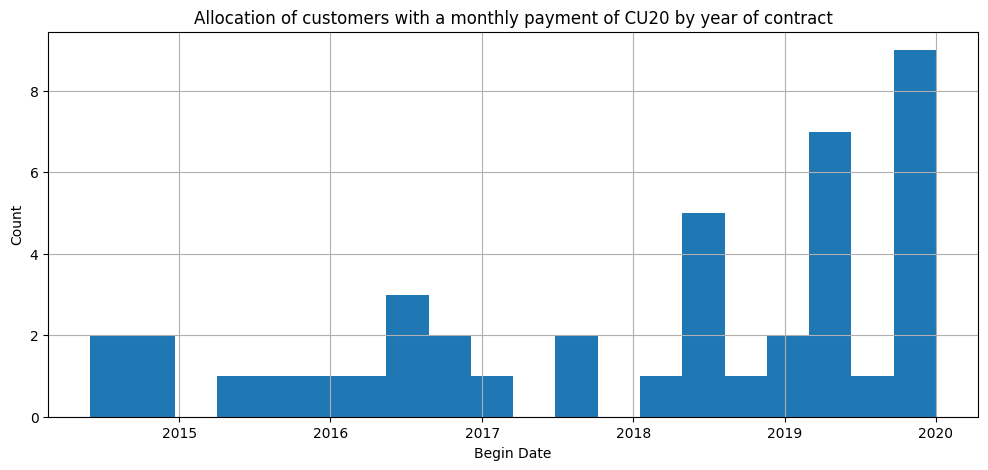

In [33]:
plt.figure(figsize=(12,5))
df.query('MonthlyCharges == 20')['BeginDate'].hist(bins=20);
plt.title("Allocation of customers with a monthly payment of CU20 by year of contract")
plt.xlabel('Begin Date')
plt.ylabel('Count')
plt.show();

Indeed, most customers with a tariff for CU 20 appeared from the end of 2019 to the beginning of 2020.

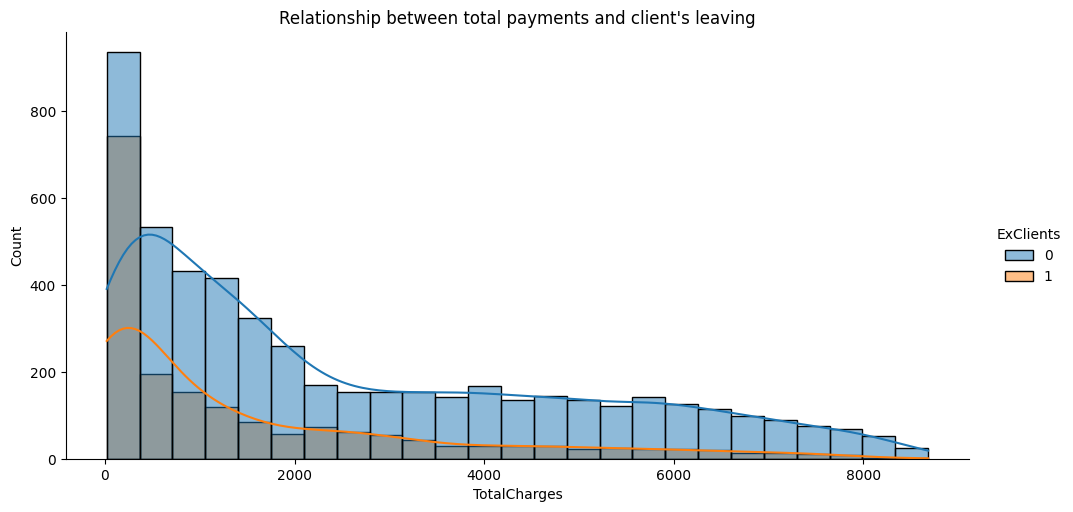

In [34]:
sns.displot(x='TotalCharges',
            hue='ExClients',
            data=df,
            height=5,
            aspect=2,
            kde=True)
plt.title("Relationship between total payments and client's leaving")
plt.show();

So, the more the customer pays, the less likely they are to terminate the contract. Most likely, this is due to the fact that there is an inverse relationship between the duration of the contract and the number of clients who left.

**Intermediate conclusions:**
* There is a growth of new clients between the end of 2019 and the beginning of 2020. Perhaps this is due to a promotion or other stimulating action;
* It is worth noting that there are only four unique values for the end date contract (I ignore the date of data collection). Perhaps this is due to the fact that the client's status is not regularly checked, only with some periodicity;
* As seen on the box plot, old clients who would use services for more than 1000 days are less likely to terminate the contract;
* As seen on the chart with monthly payments, the most popular tariff is the cheapest one, for 20 monetary units. More likely, this is due to the growth of new customers;
* A popular monthly payment interval for ex-clients is CU75-100. Perhaps the customer's company should change their tariff plans in this segment, as they may turn out to be uncompetitive ones;
* There is a noticeable connection between the summed payments and the number of clients who left. Most likely, this is a consequence of the connection already found, that the longer the clients use the services of the company, the less likely it is that they will want to terminate the contract.

After the analysis step is completed, I should remove the features that may interfere with the correct training of the model:

In [35]:
df = df.drop(['TotalCharges', 'customerID', 'BeginDate', 'EndDate'], axis=1).copy()
df.columns.values #checking


array(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'Duration', 'ExClients'],
      dtype=object)

## Models training

To solve the task of binary classification (whether the clients stays or leaves), the following models will be used:
1. Random Forest,
2. XGBoost,
3. C-Support Vector Classification.

For the estimation of quality ROC-AUC metric will be applied. Additionally, the Accuracy metric will be checked.
<br>Selection of optimal parameters and testing of models will be made by cross-validation

### Features' separation

Let's separate the target feature from the others:

In [36]:
features = df.drop(['ExClients'], axis=1)
target = df['ExClients']

Now, let's split the data on testing and training samples in a ratio of 1:3.

In [37]:
train_features, test_features, train_target, test_target = train_test_split(
                                                                      features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE
                                                                      )

train_features.shape, train_target.shape, test_features.shape, test_target.shape #checking

((5274, 17), (5274,), (1758, 17), (1758,))

### Processing of categorical features

To encode categorical features, I'm going to use:

* Ordinal Encoding (OrdinalEncoding) for all models except the SVC model,
* Direct Encoding (OneHotEncoding) for SVC model.

Let's create a list of categorical features that need to be encoded:

In [38]:
cat_list = df.columns[df.dtypes==object]

Creating a list of numerical features:

In [39]:
num_list = features.columns[features.dtypes!=object]

Creating encodings:

In [40]:
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder_ss = StandardScaler()

Transformers for encoding:

In [41]:
col_transformer_oe = make_column_transformer(
    (encoder_oe, cat_list),
    remainder='passthrough'
    )

col_transformer_ohe = make_column_transformer(
    (encoder_ohe, cat_list),
    (encoder_ss, num_list),
    remainder='passthrough'
    )

### Calculation of optimal hyperparameters, training of models and calculation of metrics

The research of optimal hyperparameters will be performed using the Pipeline construction.
<br>I'm going to use *ROC-AUC* as the basis of the metric, and check the *Accuracy* metric as an additional one.

#### For a Random Forest Classifier

Let's create the dictionary of possible hyperparameters:

In [42]:
param_forest = {'randomforestclassifier__n_estimators': range (1, 11, 2),
               'randomforestclassifier__max_depth': range (1,13, 2)
               }

Creating pipeline:

In [43]:
pipeline_forest = make_pipeline(
    col_transformer_oe, RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
    )

Using GridSearchCV for running cross-validation and fitting hyperparameters:

In [44]:
clf_forest = GridSearchCV(pipeline_forest, param_grid=param_forest, 
                          scoring=['roc_auc', 'accuracy'], refit='roc_auc', return_train_score=True,
                          cv=5)

Let's train *RandomForest* model on the training sample and get optimal hyperparameters and the main metric *ROC-AUC* and an additional one *Accuracy*:

In [45]:
clf_forest.fit(train_features, train_target)
print(f'The optimal hyperparameters for a Random Forest Classifier model: {clf_forest.best_params_}')
print(f'The ROC-AUC metric of a Random Forest Classifier model: {clf_forest.best_score_}')
print(f"The Accuracy metric of a Random Forest Classifier model: {clf_forest.cv_results_['mean_test_accuracy'].mean()}")

The optimal hyperparameters for a Random Forest Classifier model: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 9}
The ROC-AUC metric of a Random Forest Classifier model: 0.8470966079894826
The Accuracy metric of a Random Forest Classifier model: 0.7298685995725304


#### For XGBoost model

I need to repeat the same steps for the XGBoost model.

Creating a dictionary of possible hyperparameters:

In [46]:
param_xgboost = {'xgbclassifier__subsample': [0.6, 0.8, 1.0],
                 'xgbclassifier__max_depth': [3, 4, 5]
                 }

Let's start the search for optimal hyperparameters:

In [47]:
pipeline_xgb = make_pipeline(
    col_transformer_oe, XGBClassifier(random_state=RANDOM_STATE)
    )

Start GridSearchCV:

In [48]:
clf_xgb = GridSearchCV(pipeline_xgb, param_grid=param_xgboost, 
                       scoring=['roc_auc', 'accuracy'], refit='roc_auc', 
                       return_train_score=True, cv=5)

Let's train the model and display the resulting hyperparameters and two metrics:

In [49]:
clf_xgb.fit(train_features, train_target)
print(f'The optimal hyperparameters for a XGBoost model: {clf_xgb.best_params_}')
print(f'The ROC-AUC metric of a XGBoost model: {clf_xgb.best_score_}')
print(f"The Accuracy metric of a XGBoost model: {clf_xgb.cv_results_['mean_test_accuracy'].mean()}")

The optimal hyperparameters for a XGBoost model: {'xgbclassifier__max_depth': 5, 'xgbclassifier__subsample': 1.0}
The ROC-AUC metric of a XGBoost model: 0.9055327956311228
The Accuracy metric of a XGBoost model: 0.8470050850692415


#### For C-Support Vector Classification model

Let's create a dictionary of hyperparameters, and structure Pipeline. Start *GridSearchCV*, as in the previous steps:

In [50]:
param_svc = {'svc__C': [0.1, 1, 10, 100, 1000], 
             'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
             }

In [51]:
pipeline_svс = make_pipeline(
    col_transformer_ohe, SVC(random_state=RANDOM_STATE, class_weight='balanced')
    )

In [52]:
clf_svc = GridSearchCV(pipeline_svс, param_grid=param_svc, scoring=['roc_auc', 'accuracy'], 
                       refit='roc_auc', return_train_score=True, cv=5)

Let's train the model and display the resulting hyperparameters and two metrics:

In [53]:
clf_svc.fit(train_features, train_target)
print(f'The optimal hyperparameters for a SVC model: {clf_svc.best_params_}')
print(f'The ROC-AUC metric of a SVC model: {clf_svc.best_score_}')
print(f"The Accuracy metric of a SVC model: {clf_svc.cv_results_['mean_test_accuracy'].mean()}")

The optimal hyperparameters for a SVC model: {'svc__C': 100, 'svc__gamma': 0.001}
The ROC-AUC metric of a SVC model: 0.8402240742400477
The Accuracy metric of a SVC model: 0.7211813771954279


**Intermediate conclusion:**

The boosting model XGBoost turned out to be the best model.
<br>Let's check it on the test sample.

## Checking the ROC-AUC quality metric for the test sample

Let's get the prediction for the test sample and calculate *ROC-AUC* metric:

In [54]:
predictions_proba = clf_xgb.predict_proba(test_features)[:, 1] #a prediction of client's leaving
roc_auc = roc_auc_score(test_target, predictions_proba)
print(f'The metric ROC-AUC for the test sample: {roc_auc}')

The metric ROC-AUC for the test sample: 0.9164442682580938


The chart of the ROC curve for the resulting XGBoost  model:

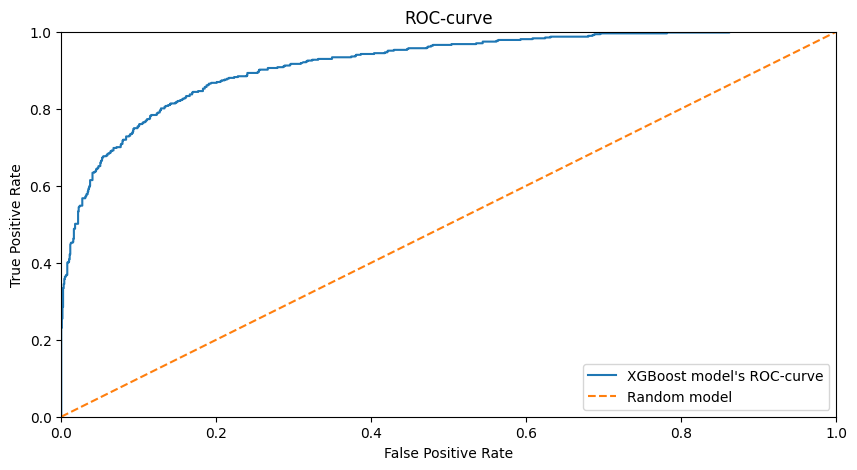

In [55]:
fpr, tpr, thresholds = roc_curve(test_target, predictions_proba, pos_label=1)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="XGBoost model's ROC-curve")
plt.plot([0, 1], [0, 1], linestyle='--', label='Random model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend()
plt.show();

The area under the curve is quite large, which indicates a good accuracy of the chosen model.

Let's build a feature importance graph for the XGBoost model:

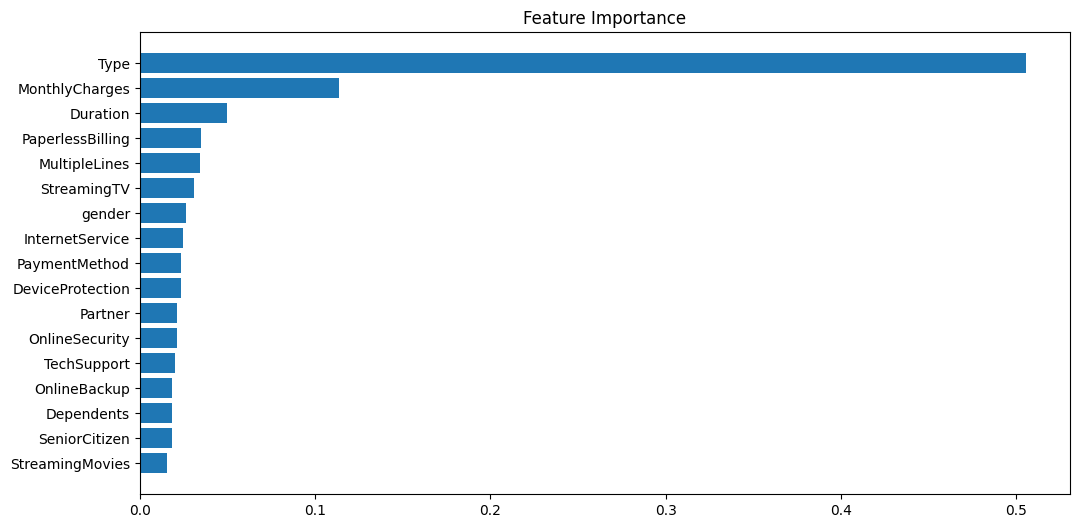

In [56]:
feature_importance = clf_xgb.best_estimator_.steps[1][1].feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test_features.columns)[sorted_idx])
plt.title('Feature Importance');

As seen, the most important feature of the chosen model is the type of client's tariff.

## Main conclusions

**General conclusion**

In the **Telecom** project, I had to build a model to predict customer churn.
<br>Four tables were provided by the customer as given data:
1. contract.csv - information about the contract,
2. personal.csv - personal data of the client,
3. internet.csv - information about the Internet services,
4. phone.csv - information about phone services.

The following steps were taken to solve the problem:
* To prepare data for analysis and model building, I:
     * merged four data tables into one dataframe using the common field `CustomerID`;
     * converted all features to their expected types;
     * checked that there are no explicit and implicit duplicates;
     * checked numerical data for anomalies;
     * created an additional attribute - `Duration` (service usage duration), as the difference between the `EndDate` and `BeginDate` attributes. In case there is no contract end date yet, I substituted the data collection date with 01-02-2020;
     * created a target attribute `ExClients` - whether the person is a current client or not. The binary categorical feature was formed using the `EndDate` attribute: 0 - there is no contract end date in the source data, 1 - the contract end date is known.
* Then I proceeded to the data analysis step:
     * checked numerical features for Pearson's correlation. I noticed that the feature `TotalCharges` (total payments) strongly correlates with the other two: `MonthlyCharges` and `Duration`. This means that it does not bring much new benefit to prediction models. Based on this, I decided to remove this feature;
     * checked all features of the dataset for multicollinearity using correlation *Phik*. Based on the analysis, I decided to remove the features:
         * `customerID` - it is unique for each object, has no meaning for the learning model,
         * `EndDate` - correlates with the target feature,
         * `BeginDate` - correlates with the `Duration` At the same time using it may make it possible to restore the `EndDate` feature;
     * checked how the start and end dates of the contract are distributed. It turned out that the largest growth in new customers occurred at the turn of 2019-2020;
     * checked the connection of the target feature with the duration of the contract and monthly and general payments. It turned out that:
         * customers who use the services for more than 1000 days are less likely to terminate the contract,
         * the most popular tariff among existing customers is for 20 monetary units, which is most likely due to the growth of new customers,
         * more all former clients with monthly payments in the range of CU 75-100.
* The main part of the project is training models. For that, I:
     * divided the features into two groups: the target `ExClients` and the rest. Each of these two groups was divided into training and testing. After the features were removed in the analysis stage, the following remained as features for training:
         * `Type`,
         * `PaperlessBilling`,
         * `PaymentMethod`,
         * `MonthlyCharges`,
         * `Internet Service`,
         * `OnlineSecurity`,
         * `Online Backup`,
         * `DeviceProtection`,
         * `TechSupport`,
         * `StreamingTV`,
         * `StreamingMovies`,
         * `gender`,
         * `Senior Citizen`,
         * `Partner`,
         * `Dependents`,
         * `MultipleLines`,
         * `Duration`.
     * Created encoders for linear and non-linear models;
     * To solve the problem, I tested three models: Random Forest, XGBoost, and SVC. For each of the three models, I:
         * made a selection of hyperparameters using *Pipeline*,
         * calculated the ROC-AUC metric on optimal hyperparameters as the average of five *GridSearchCV* iterations. The metric is key to solving the problem since this metric takes into account trade-offs between accuracy and recall;
         * computed the Accuracy metric.
     * The best model turned out - **XGBoost**:
         * Optimal hyperparameters: max_depth: 5, subsample: 1.0;
         * ROC-AUC = 0.90295;
         * Accuracy = 0.8442.
* On the test set, the XGBoost model showed ROC-AUC = 0.91248.

**Constants used:**
<br>The size of the test sample was taken as 0.25.
<br>Parameter *random_state* = 13032023.

**Key milestones:**
1. To find where to get the target feature;
2. To generate the correct additional training feature. As the feature importance graph shows, it is in the top three;
3. Correctly identify the fields that need to be deleted;
4. To code categorical features and numerical features for linear models.
<br>I think, that the points listed above could have influenced the value of the metric being checked.